# Prepare dataset

In [1]:
!unzip -qq /kaggle/input/dogs-vs-cats/train.zip

In [ ]:
# !unzip -qq /kaggle/input/dogs-vs-cats/test1.zip

# Import libraries

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import cv2
import glob
from keras.applications.vgg19 import VGG19, preprocess_input
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.svm import SVC
import contextlib
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Preprocess data

In [4]:
img_size = 224
def get_data(normal_dir, pneumonia_dir):
    x = []
    y = []
    for filename in os.listdir(normal_dir):
        if filename.endswith('jpeg') or filename.endswith('jpg'):
            img_path = os.path.join(normal_dir, filename)
            x.append(img_path)
            y.append(0)
    for filename in os.listdir(pneumonia_dir):
        if filename.endswith('jpeg') or filename.endswith('jpg'):
            img_path = os.path.join(pneumonia_dir, filename)
            x.append(img_path)
            y.append(1)
    return x, np.array(y)

In [5]:
def get_data(DATA_DIR):
    X, y = [], []
    for filename in os.listdir(DATA_DIR):
        X.append(os.path.join(DATA_DIR, filename)) 
        if filename.split('.')[0] == 'dog':
            y.append(1)
        elif filename.split('.')[0] == 'cat':
            y.append(0)
    return X, np.array(y)

In [6]:
X, y = get_data('/kaggle/working/train')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# EDA

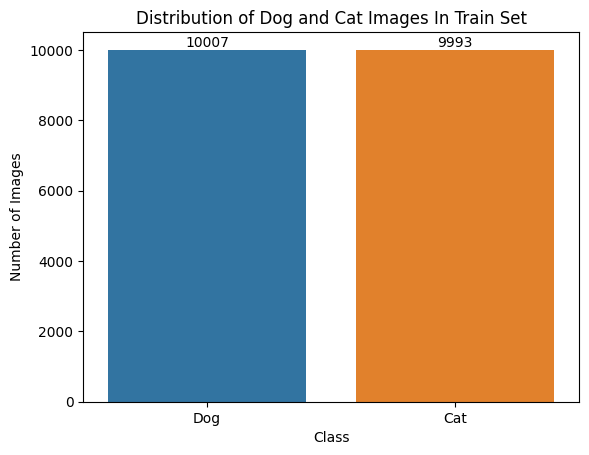

In [8]:
ax = sns.barplot(x=['Dog', 'Cat'], y=[np.sum(y_train == 1), np.sum(y_train == 0)])

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Dog and Cat Images In Train Set')
for container in ax.containers:
    ax.bar_label(container)

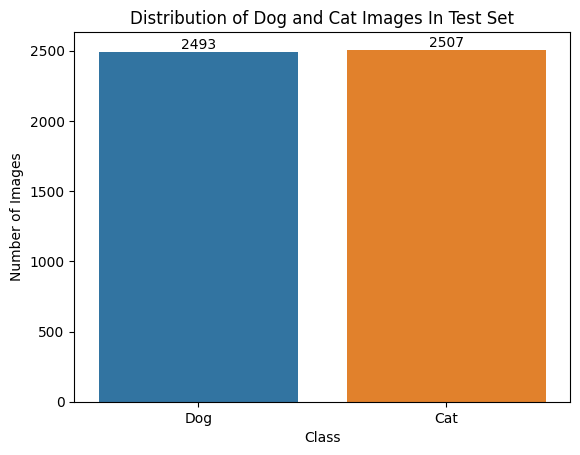

In [9]:
ax = sns.barplot(x=['Dog', 'Cat'], y=[np.sum(y_test == 1), np.sum(y_test == 0)])

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Dog and Cat Images In Test Set')
for container in ax.containers:
    ax.bar_label(container)

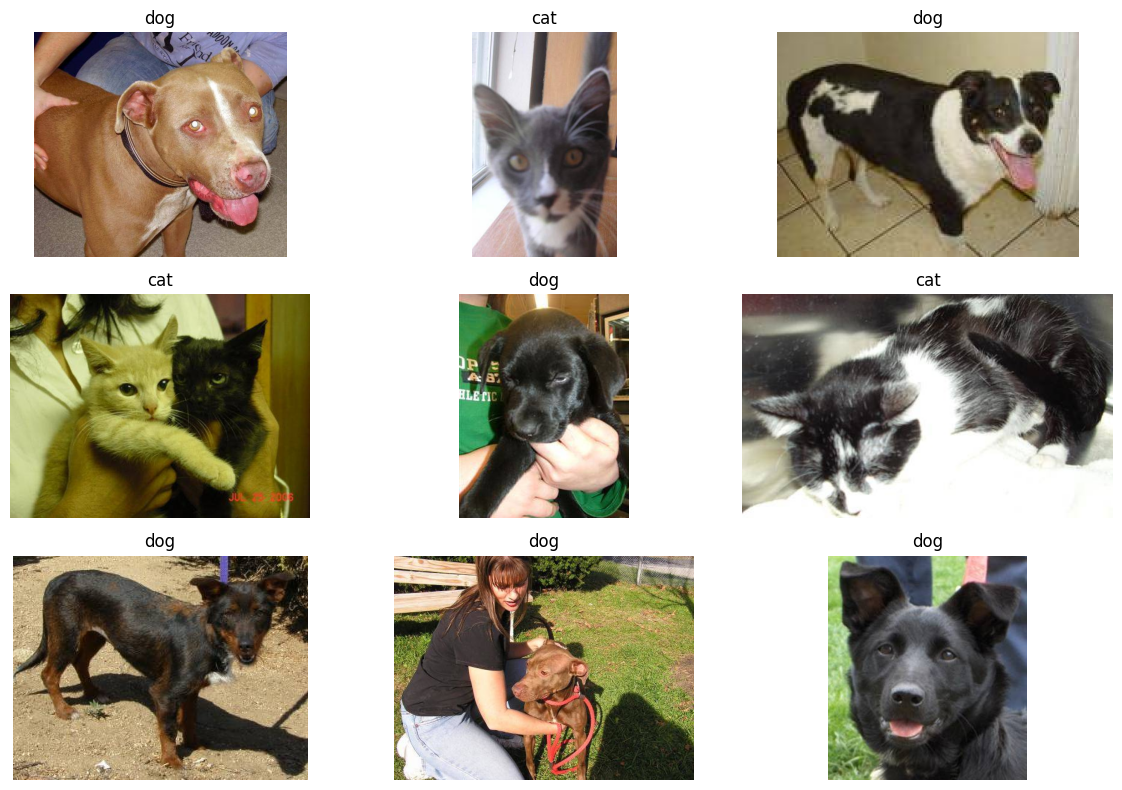

In [11]:
image_dir = '/kaggle/working/train'

image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

plt.figure(figsize=(12, 8))

for i, image_path in enumerate(image_paths[:9]):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    label = os.path.basename(image_path).split('.')[0]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Extract feature

In [12]:
base_model = VGG19(weights='imagenet', include_top=False)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    features_flattened = features.flatten()
    return features_flattened

In [14]:
features_train = []
for img_path in tqdm(X_train, desc="Extracting Features"):
    with open('/dev/null', 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            features = extract_features(img_path)
            features_train.append(features)

features_train = np.array(features_train)

Extracting Features:   0%|          | 0/20000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1731665896.376039     113 service.cc:145] XLA service 0x7d440800a510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731665896.376093     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731665898.372614     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting Features: 100%|██████████| 20000/20000 [21:26<00:00, 15.54it/s]


In [15]:
features_test = []
for img_path in tqdm(X_test, desc="Extracting Features"):
    with open('/dev/null', 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            features = extract_features(img_path)
            features_test.append(features)

features_test = np.array(features_test)

Extracting Features: 100%|██████████| 5000/5000 [05:24<00:00, 15.43it/s]


# Train classifier (SVM)

In [20]:
svm_model = SVC(kernel='rbf')
svm_model.fit(features_train, y_train)

SVC()

# Evaluate and save model

In [21]:
y_pred = svm_model.predict(features_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2507
           1       0.99      0.99      0.99      2493

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [22]:
import pickle
with open('svm_model.pkl','wb') as f:
    pickle.dump(svm_model,f)

# Plot some error predictions

Number of incorrect predictions: 59


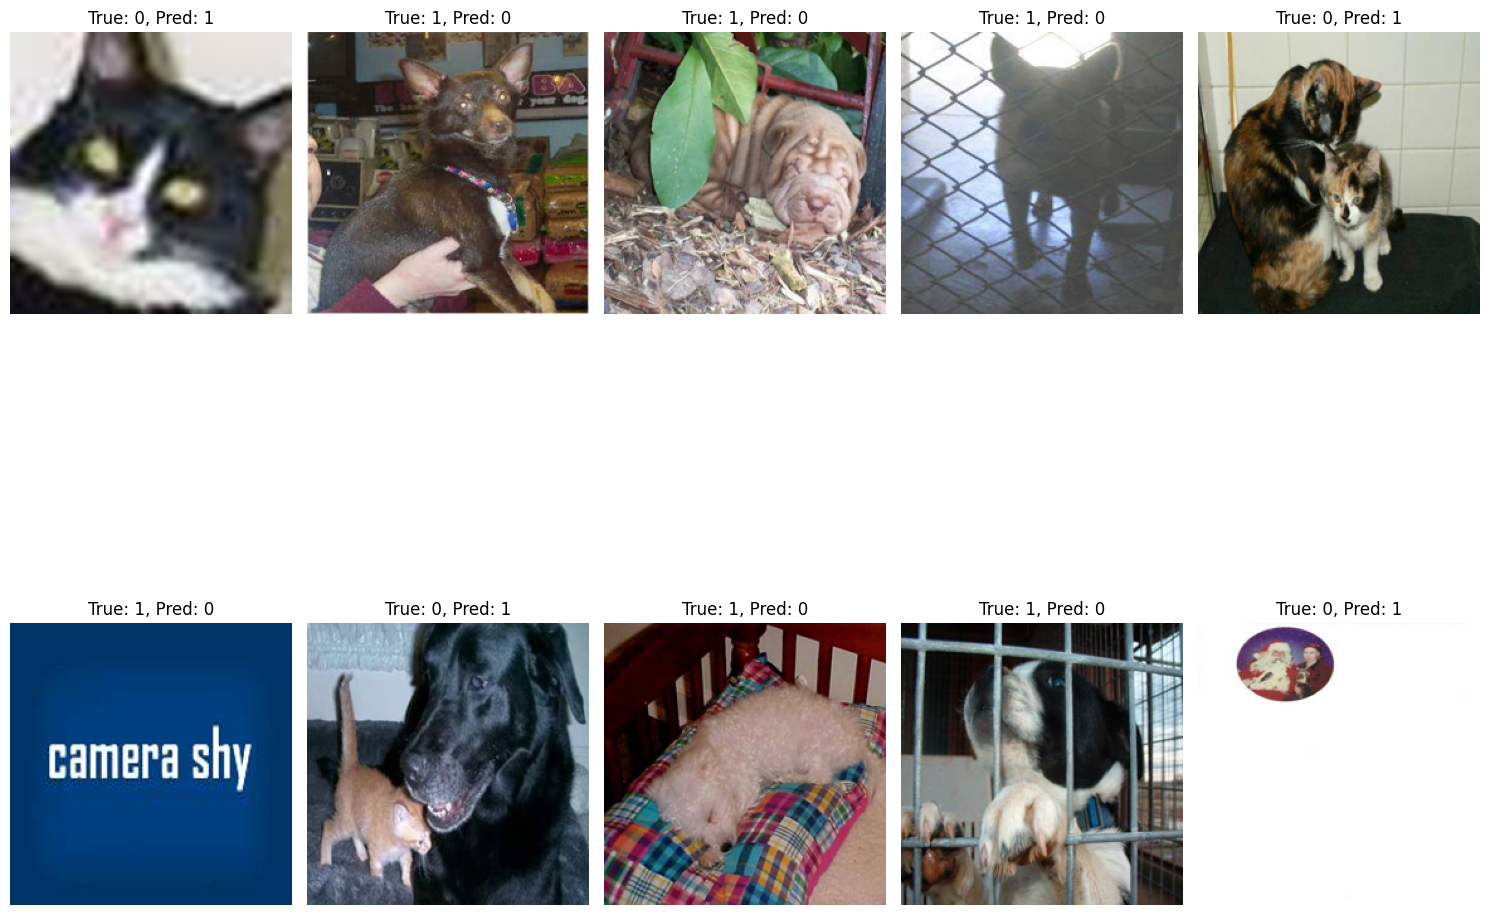

In [ ]:
from PIL import Image
incorrect_idx = np.where(y_test != y_pred)[0]

num_incorrect = len(incorrect_idx)
print(f"Number of incorrect predictions: {num_incorrect}")

num_display = min(num_incorrect, 10)

plt.figure(figsize=(15, 15))
for i in range(num_display):
    idx = incorrect_idx[i]
    img_path = X_test[idx]

    img = Image.open(img_path)

    img = img.resize((224, 224))

    img_array = np.array(img)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img_array)
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Test some others model

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(features_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn_model.predict(features_test)
# Evaluate using classification_report
report = classification_report(y_test, y_pred)
print("K-Nearest Neighbors (KNN) Classification Report:\n", report)

K-Nearest Neighbors (KNN) Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      2509
           1       0.98      0.84      0.90      2491

    accuracy                           0.91      5000
   macro avg       0.92      0.91      0.91      5000
weighted avg       0.92      0.91      0.91      5000



In [ ]:
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(features_train, y_train)
# Make predictions on the test set
y_pred = naive_bayes_model.predict(features_test)
# Evaluate using classification_report
report = classification_report(y_test, y_pred)
print("Naive Bayes Classification Report:\n", report)

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2509
           1       0.96      0.96      0.96      2491

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(features_train, y_train)
# Make predictions on the test set
y_pred = random_forest_model.predict(features_test)
# Evaluate using classification_report
report = classification_report(y_test, y_pred)
print("Random Forest Classification Report:\n", report)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      2509
           1       0.97      0.98      0.98      2491

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

